# Prediction of Students' Dropout and Academic Success - Classification with Dimensionality Reduction
Neil John Catapang

## Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import numpy as np
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE

from time import time

## Reading the Dataset + EDA + Cleaning

In [2]:
student_df = pd.read_csv("data.csv", sep=';')
pd.options.display.max_columns = None

display(student_df)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,5,4,122.2,0,0,0,1,1,0,19,0,0,6,7,5,13.600000,0,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,9,9,119.0,1,0,1,0,0,0,18,1,0,6,6,6,12.000000,0,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,9,9,149.5,1,0,0,1,0,1,30,0,0,7,8,7,14.912500,0,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,7,4,153.8,1,0,0,1,0,1,20,0,0,5,5,5,13.800000,0,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


The dataset is composed of 36 features, and one column of target labels which indicate academic success of each example (student).

In [3]:
print("Dataset information:")
print(student_df.info(), "\n")

print(f"Dataset Summary: \n{student_df.describe(include="all")}")

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualificati

No missing data. All are numeric data (some features are categorical (encoded), while some are continuous or ordinal).

In [4]:
# Encode labels for inclusion in heatmap
target_map = {'Dropout': 0, 'Enrolled': 1, "Graduate": 2}
target_encoded = student_df['Target'].map(target_map)
student_df_encoded = pd.concat([student_df.drop(columns=['Target']), target_encoded], axis=1)

Heatmap of features (including the target) were plotted below to see if there are highly-correlated features, as well as features that show correlation with the target label (possible important features).

c:\Users\Neil Catapang\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\Neil Catapang\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


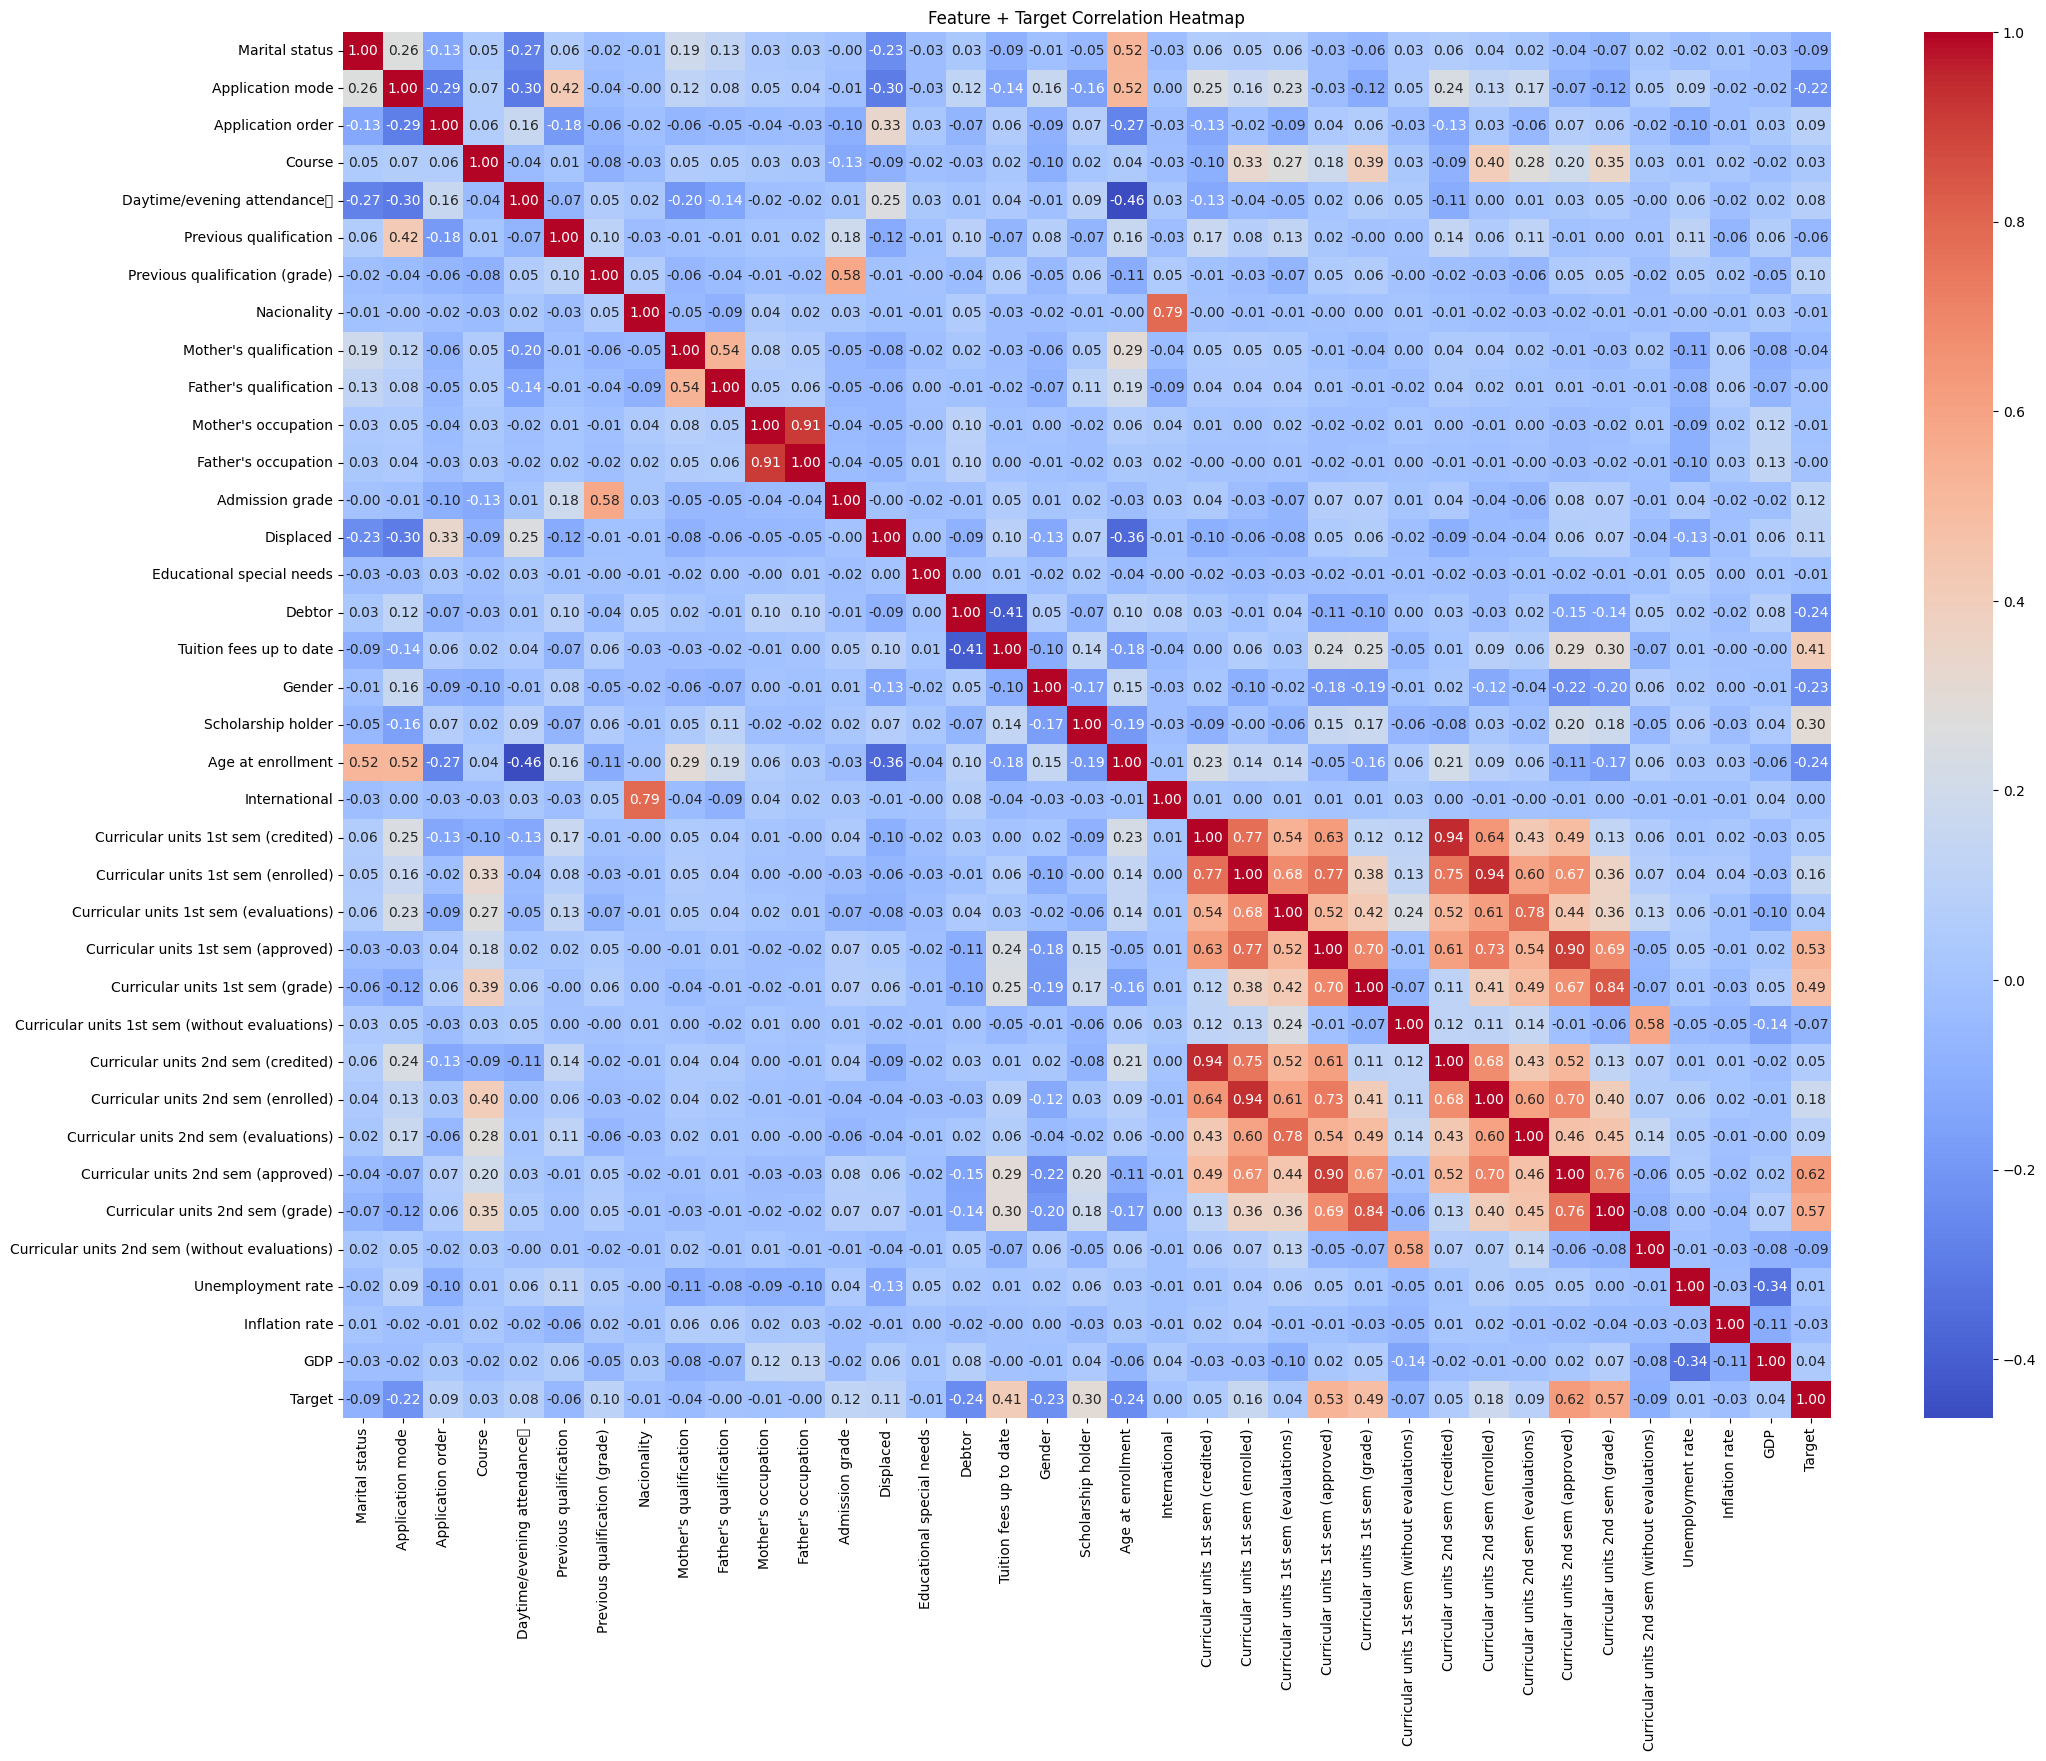

In [5]:
corr_matrix = student_df_encoded.corr()

plt.figure(figsize=(24, 18))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature + Target Correlation Heatmap")
plt.show()

There is high correlation observed from a few pair of features (>= 0.90), including:
1. Curricular units 1st sem (credited) vs. Curricular units 2nd sem (credited): 0.94
2. Curricular units 1st sem (enrolled) vs. Curricular units 2nd sem (enrolled): 0.94
3. Mother's occupation vs. Father's Occupation: 0.91
4. Curricular units 1st sem (approved) vs. Curricular units 2nd sem (approved): 0.90

One in each pair of features were removed (in succeeding parts of this notebook) to improve the performance of the model.


There is moderate correlation between curricular units and the target. This would give us an idea on the importance of these features in predicting the students' status/academic success.

Target
Graduate    0.499322
Dropout     0.321203
Enrolled    0.179476
Name: proportion, dtype: float64

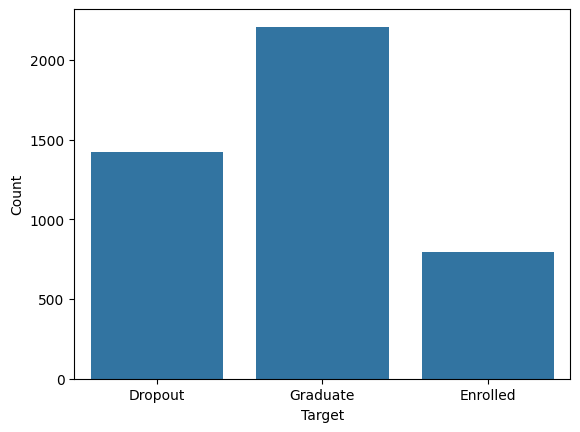

In [6]:
sns.countplot(x='Target', data=student_df)
plt.ylabel('Count')
student_df['Target'].value_counts(normalize=True)

There is noticeable class imbalance in this dataset, favoring the 'Graduate' class. This will be addressed using Synthetic Minority Oversampling Technique.

### Dataset Cleaning (Removing Highly-Correlated Features)

In [7]:
# Index the columns based on their type (categorical or numeric)
categorical_features = [
    0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 
    13, 14, 15, 16, 17, 18, 20
]

numeric_features = [
    6, 12, 19, 23, 25, 26, 27, 28, 
    29, 30, 31, 32, 33, 34, 35
]

removed_features = [
    10, 21, 22, 24
]

X_categorical = student_df_encoded.iloc[:, categorical_features]
X_numeric = student_df_encoded.iloc[:, numeric_features]
y = student_df_encoded.iloc[:, 36]

In [8]:
student_df_cleaned = pd.concat([X_categorical, X_numeric, y], axis=1)
display(student_df_cleaned)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,International,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (evaluations),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,1,19,12,9,1,0,0,1,1,0,0,122.0,127.3,20,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,15,1,9254,1,1,1,1,3,3,1,0,0,0,1,0,0,160.0,142.5,19,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,2
2,1,1,5,9070,1,1,1,37,37,9,1,0,0,0,1,0,0,122.0,124.8,19,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,17,2,9773,1,1,1,38,37,3,1,0,0,1,0,0,0,122.0,119.6,20,8,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,2
4,2,39,1,8014,0,1,1,37,38,9,0,0,0,1,0,0,0,100.0,141.5,45,9,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,1,1,1,4,0,0,0,1,1,0,0,125.0,122.2,19,7,13.600000,0,0,6,8,5,12.666667,0,15.5,2.8,-4.06,2
4420,1,1,2,9773,1,1,105,1,1,9,1,0,1,0,0,0,1,120.0,119.0,18,6,12.000000,0,0,6,6,2,11.000000,0,11.1,0.6,2.02,0
4421,1,1,1,9500,1,1,1,37,37,9,1,0,0,1,0,1,0,154.0,149.5,30,8,14.912500,0,0,8,9,1,13.500000,0,13.9,-0.3,0.79,0
4422,1,1,1,9147,1,1,1,37,37,4,1,0,0,1,0,1,0,180.0,153.8,20,5,13.800000,0,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,2


After removing highly-correlated features, the cleaned dataset now only has 32 features.

## Creating Models to Predict Students' Status

### SVC without Dimensionality Reduction

In [9]:
X1 = student_df_cleaned.drop(columns=['Target'])
y1 = y

# Oversampling the dataset to balance classes
oversample = SMOTE(random_state=42)
X1_over, y1_over = oversample.fit_resample(X1, y1)


X1_train, X1_test, y1_train, y1_test = train_test_split(X1_over, y1_over, test_size=0.30, random_state=42, stratify=y1_over)
print(f'SVC - Students Academic Success Prediction')
print(X1_train.shape)
print(X1_test.shape)

SVC - Students Academic Success Prediction
(4638, 32)
(1989, 32)


In [10]:
from collections import Counter

y1_train_count = Counter(y1_train)
y1_test_count = Counter(y1_test)

y1_train_ratio = Counter({key: round(value*100 / y1_train.shape[0], 2) for key, value in y1_train_count.items()})
y1_test_ratio = Counter({key: round(value*100/ y1_test.shape[0], 2) for key, value in y1_test_count.items()})

print(f'Train dataset class distribution ratio: \n{y1_train_ratio}')
print(f'Test dataset class distribution ratio: \n{y1_test_ratio}')

Train dataset class distribution ratio: 
Counter({0: 33.33, 1: 33.33, 2: 33.33})
Test dataset class distribution ratio: 
Counter({0: 33.33, 2: 33.33, 1: 33.33})


Stratification of train-test split resulted in two datasets with similar class distribution.

Similarly, stratification were also applied in K-fold validation of all models created in this notebook to ensure similar distribution of classes among all splits.

In [11]:
# The base support vector classifier pipeline
base_svm = make_pipeline(StandardScaler(), SVC())

# Specify grid of hyperparameters
param_grid1 = {
    "estimator__svc__C": [0.01, 0.1, 1, 10, 100, 1000],
    "estimator__svc__kernel": ["rbf", "poly", "sigmoid"],   # linear not included due to low correlation scores in EDA
    "estimator__svc__gamma": ["scale", "auto"],
    "estimator__svc__degree": [2, 3, 4]
}

kfoldcv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid1_ovo = GridSearchCV(OneVsOneClassifier(base_svm), param_grid1, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)
grid1_ovr = GridSearchCV(OneVsRestClassifier(base_svm), param_grid1, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start1 = time() 

grid1_ovo.fit(X1_train, y1_train)
grid1_ovr.fit(X1_train, y1_train)

print("GridSearchCV took %.2f seconds." % (time() - start1))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
GridSearchCV took 496.23 seconds.


In [12]:
best_model_1_ovo = grid1_ovo.best_estimator_
print("SVC-OvO")
print("Best Parameters:", grid1_ovo.best_params_)
print("Best Accuracy:", grid1_ovo.best_score_)

best_model_1_ovr = grid1_ovr.best_estimator_
print("SVC-OvR")
print("Best Parameters:", grid1_ovr.best_params_)
print("Best Accuracy:", grid1_ovr.best_score_)

SVC-OvO
Best Parameters: {'estimator__svc__C': 10, 'estimator__svc__degree': 2, 'estimator__svc__gamma': 'scale', 'estimator__svc__kernel': 'rbf'}
Best Accuracy: 0.7932371294126399
SVC-OvR
Best Parameters: {'estimator__svc__C': 10, 'estimator__svc__degree': 2, 'estimator__svc__gamma': 'scale', 'estimator__svc__kernel': 'rbf'}
Best Accuracy: 0.7934540415876205


In [13]:
# SVC-OvO-GridSearch - Accuracy and Confusion Matrix
print('SVC-OvO')
print(f"Accuracy = {best_model_1_ovo.score(X1_test, y1_test)}")
print('Confusion Matrix')
y1_test_pred_ovo = best_model_1_ovo.predict(X1_test)
print(confusion_matrix(y1_test, y1_test_pred_ovo))

# SVC-OvO-GridSearch - Classification Report
print(classification_report(y1_test, y1_test_pred_ovo, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC-OvO
Accuracy = 0.7863247863247863
Confusion Matrix
[[487 114  62]
 [ 55 519  89]
 [ 29  76 558]]
              precision    recall  f1-score   support

     Dropout       0.85      0.73      0.79       663
    Enrolled       0.73      0.78      0.76       663
    Graduate       0.79      0.84      0.81       663

    accuracy                           0.79      1989
   macro avg       0.79      0.79      0.79      1989
weighted avg       0.79      0.79      0.79      1989



In [14]:
# SVC-OvR-GridSearch - Accuracy and Confusion Matrix
print('SVC-OvR')
print(f"Accuracy = {best_model_1_ovr.score(X1_test, y1_test)}")
print('Confusion Matrix')
y1_test_pred_ovr = best_model_1_ovr.predict(X1_test)
print(confusion_matrix(y1_test, y1_test_pred_ovr))

# SVC-OvR-GridSearch - Classification Report
print(classification_report(y1_test, y1_test_pred_ovr, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC-OvR
Accuracy = 0.7853192559074912
Confusion Matrix
[[477 113  73]
 [ 50 524  89]
 [ 31  71 561]]
              precision    recall  f1-score   support

     Dropout       0.85      0.72      0.78       663
    Enrolled       0.74      0.79      0.76       663
    Graduate       0.78      0.85      0.81       663

    accuracy                           0.79      1989
   macro avg       0.79      0.79      0.79      1989
weighted avg       0.79      0.79      0.79      1989



SVC models with OvO and OvR classification methods performed similarly, with SVC-OvO performing slightly better with 78.6% accuracy and 79% weighted F1-score.

### Logistic Regression Model without Dimensionality Reduction

In [15]:
# The base support vector classifier pipeline
base_logreg = make_pipeline(StandardScaler(), LogisticRegression())

# Specify grid of hyperparameters
param_grid_2 = {
    'estimator__logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'estimator__logisticregression__penalty': ['l2'],
    'estimator__logisticregression__solver': ['liblinear', 'saga', 'newton-cg']
}

grid2_ovo = GridSearchCV(OneVsOneClassifier(base_logreg), param_grid_2, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)
grid2_ovr = GridSearchCV(OneVsRestClassifier(base_logreg), param_grid_2, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start2 = time() 
grid2_ovo.fit(X1_train, y1_train)
grid2_ovr.fit(X1_train, y1_train)

print("GridSearchCV took %.2f seconds."
      % (time() - start2))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits
GridSearchCV took 4.74 seconds.


In [16]:
best_model_2_ovo = grid2_ovo.best_estimator_
print("LR-OvO")
print("Best Parameters:", grid2_ovo.best_params_)
print("Best Accuracy:", grid2_ovo.best_score_)

best_model_2_ovr = grid2_ovr.best_estimator_
print("LR-OvR")
print("Best Parameters:", grid2_ovr.best_params_)
print("Best Accuracy:", grid2_ovr.best_score_)

LR-OvO
Best Parameters: {'estimator__logisticregression__C': 100, 'estimator__logisticregression__penalty': 'l2', 'estimator__logisticregression__solver': 'liblinear'}
Best Accuracy: 0.7583072945727782
LR-OvR
Best Parameters: {'estimator__logisticregression__C': 100, 'estimator__logisticregression__penalty': 'l2', 'estimator__logisticregression__solver': 'liblinear'}
Best Accuracy: 0.748390014135327


In [17]:
# LR-OvO-GridSearch - Accuracy and Confusion Matrix
print('LR-OvO')
print(f"Accuracy = {best_model_2_ovo.score(X1_test, y1_test)}")
print('Confusion Matrix')
y1_test_pred_ovo2 = best_model_2_ovo.predict(X1_test)
print(confusion_matrix(y1_test, y1_test_pred_ovo2))

# LR-OvO-GridSearch - Classification Report
print(classification_report(y1_test, y1_test_pred_ovo2, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR-OvO
Accuracy = 0.7410759175465058
Confusion Matrix
[[476 126  61]
 [ 98 446 119]
 [ 23  88 552]]
              precision    recall  f1-score   support

     Dropout       0.80      0.72      0.76       663
    Enrolled       0.68      0.67      0.67       663
    Graduate       0.75      0.83      0.79       663

    accuracy                           0.74      1989
   macro avg       0.74      0.74      0.74      1989
weighted avg       0.74      0.74      0.74      1989



In [18]:
# LR-OvR-GridSearch - Accuracy and Confusion Matrix
print('LR-OvR')
print(f"Accuracy = {best_model_2_ovr.score(X1_test, y1_test)}")
print('Confusion Matrix')
y1_test_pred_ovr2 = best_model_2_ovr.predict(X1_test)
print(confusion_matrix(y1_test, y1_test_pred_ovr2))

# LR-OvR-GridSearch - Classification Report
print(classification_report(y1_test, y1_test_pred_ovr2, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR-OvR
Accuracy = 0.730517848164907
Confusion Matrix
[[480 121  62]
 [110 424 129]
 [ 22  92 549]]
              precision    recall  f1-score   support

     Dropout       0.78      0.72      0.75       663
    Enrolled       0.67      0.64      0.65       663
    Graduate       0.74      0.83      0.78       663

    accuracy                           0.73      1989
   macro avg       0.73      0.73      0.73      1989
weighted avg       0.73      0.73      0.73      1989



LogReg model with OvO classification also performed slightly better than LogReg-OvR, with accuracy of 74.1% and weighted F1 score of 74%. 

SVC was found to perform better than logistic regression classifier in this dataset, given that no dimensionality reduction was performed. This emphasizes the capacity of the support vector classifier with radial basis function (rbf) kernel to capture more complex patterns in this dataset than the logistic regression classifier.

### SVC with PCA

To proceed with PCA, I decided to first find the minimum number of principal components that explain 95% of the variance in the numeric features.

1 0.275
2 0.41
3 0.517
4 0.608
5 0.69
6 0.757
7 0.81
8 0.855
9 0.897
10 0.925
11 0.952
12 0.969
13 0.983
14 0.994
15 1.0


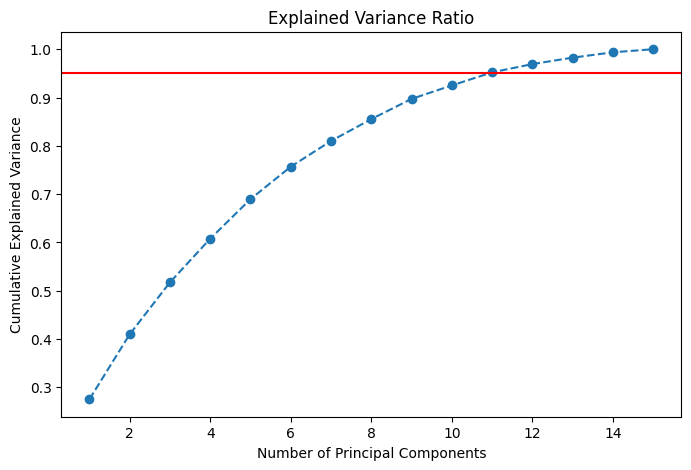

Optimal n_components (95% variance): 11


In [19]:
scaler = StandardScaler()
X_cat_scaled = scaler.fit_transform(X_categorical)
X_num_scaled = scaler.fit_transform(X_numeric)

pca_trial = PCA()
pca_trial.fit(X_num_scaled)

cumulative_variance = np.cumsum(pca_trial.explained_variance_ratio_)
for i, ratio in enumerate(cumulative_variance, 1):
    print(i, np.round(ratio, 3))

# Plot cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

n_components_optimal = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal n_components (95% variance): {n_components_optimal}")

The optimal number of PC found which explains at least 95% variance is <code>11</code>. This was used in transforming the numeric feature space to a lower-dimensional space.

In [20]:
pca = PCA(n_components=n_components_optimal)
X2_numeric = pca.fit_transform(X_num_scaled)

X2_cat_df = pd.DataFrame(X_cat_scaled, columns=X_categorical.columns)
X2_num_df = pd.DataFrame(X2_numeric, columns=[f'PC{i+1}' for i in range(X2_numeric.shape[1])])
X2 = pd.concat([X2_cat_df, X2_num_df], axis=1)
y2 = y

display(X2)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,International,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-0.294829,-0.095470,2.490896,-4.209520,0.350082,-0.35023,-0.126298,-0.036018,-0.669778,-0.080456,0.907512,-0.107993,-0.358167,0.368135,1.357640,-0.574914,-0.159682,-4.949614,0.173760,-0.561587,-0.284678,0.575390,-0.027628,-0.831245,-0.349722,0.310974,-0.803892,-0.364818
1,-0.294829,-0.209869,-0.554068,0.192580,0.350082,-0.35023,-0.126298,-1.189759,-1.256427,-0.317984,0.907512,-0.107993,-0.358167,-2.716392,1.357640,-0.574914,-0.159682,0.184424,-1.933457,1.920118,-0.255901,-0.083097,-1.172333,-0.148358,-0.181644,0.441346,0.554160,0.568310
2,-0.294829,-1.010660,2.490896,0.103404,0.350082,-0.35023,-0.126298,1.117723,0.959802,-0.080456,0.907512,-0.107993,-0.358167,-2.716392,1.357640,-0.574914,-0.159682,-3.841500,0.495865,-0.741899,0.001017,0.947715,-0.029404,-1.687461,-0.630278,0.464938,-0.331933,-0.125504
3,-0.294829,-0.095470,0.207173,0.444115,0.350082,-0.35023,-0.126298,1.181819,0.959802,-0.317984,0.907512,-0.107993,-0.358167,0.368135,-0.736572,-0.574914,-0.159682,0.443738,-0.186995,-0.715828,-0.367878,-1.079192,-0.873491,0.096199,-0.107142,-1.828138,0.148906,-0.609650
4,1.356212,1.162916,-0.554068,-0.408389,-2.856470,-0.35023,-0.126298,1.117723,1.024985,-0.080456,-1.101914,-0.107993,-0.358167,0.368135,-0.736572,-0.574914,-0.159682,0.308411,0.555237,-1.067832,0.799010,0.239560,-1.831974,2.354035,-1.702663,0.673957,-1.724399,-0.796246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,-0.294829,-1.010660,3.252137,0.444115,0.350082,-0.35023,-0.126298,-1.189759,-1.386793,-0.278396,-1.101914,-0.107993,-0.358167,0.368135,1.357640,-0.574914,-0.159682,0.227908,-0.248086,0.135559,1.566061,-2.132962,0.890981,-0.145725,-0.380691,0.007013,-0.230967,-0.252604
4420,-0.294829,-1.010660,0.207173,0.444115,0.350082,-0.35023,14.916228,-1.189759,-1.386793,-0.080456,0.907512,-0.107993,2.791994,-2.716392,-0.736572,-0.574914,6.262442,-0.762212,-0.495733,-1.259837,-0.769242,-0.300068,-0.354592,-0.337647,-0.004819,0.323963,-0.296558,-0.091029
4421,-0.294829,-1.010660,-0.554068,0.311805,0.350082,-0.35023,-0.126298,1.117723,0.959802,-0.080456,0.907512,-0.107993,-0.358167,0.368135,-0.736572,1.739390,-0.159682,0.409478,-0.889289,1.793749,0.218536,0.571890,-1.420794,1.237118,0.506249,0.561172,0.262235,0.224130
4422,-0.294829,-1.010660,-0.554068,0.140722,0.350082,-0.35023,-0.126298,1.117723,0.959802,-0.278396,0.907512,-0.107993,-0.358167,0.368135,-0.736572,1.739390,-0.159682,-0.391729,-2.100615,3.478116,-0.435559,0.465444,-0.836219,0.240322,-0.087862,-1.828804,1.332520,0.266841


In [21]:
# Oversampling the dataset to balance classes
X2_over, y2_over = oversample.fit_resample(X2, y2)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2_over, y2_over, test_size=0.30, random_state=42, stratify=y2_over)
print(f'SVC + PCA - Students Academic Success Prediction')
print(X2_train.shape)
print(X2_test.shape)

SVC + PCA - Students Academic Success Prediction
(4638, 28)
(1989, 28)


In [22]:
# The base support vector classifier pipeline
svc = SVC()

# Specify grid of hyperparameters
param_grid_3 = {
    "C": [0.01, 0.1, 1, 10, 100, 1000],
    "kernel": ["rbf", "poly", "sigmoid"],
    "gamma": ["scale", "auto"],
    "degree": [2, 3, 4]
}

grid3 = GridSearchCV(svc, param_grid_3, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start3 = time() 
grid3.fit(X2_train, y2_train)
print("GridSearchCV took %.2f seconds." % (time() - start3))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
GridSearchCV took 163.37 seconds.


In [23]:
best_model_3 = grid3.best_estimator_
print("SVC + PCA")
print("Best Parameters:", grid3.best_params_)
print("Best Accuracy:", grid3.best_score_)

SVC + PCA
Best Parameters: {'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best Accuracy: 0.7992692872819254


In [24]:
# SVC-PCA-GridSearch - Accuracy and Confusion Matrix
print('SVC + PCA')
print(f"Accuracy = {best_model_3.score(X2_test, y2_test)}")
print('Confusion Matrix')
y2_test_pred = best_model_3.predict(X2_test)
print(confusion_matrix(y2_test, y2_test_pred))

# SVC-PCA-GridSearch - Classification Report
print(classification_report(y2_test, y2_test_pred, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + PCA
Accuracy = 0.8320764203117145
Confusion Matrix
[[561  54  48]
 [ 35 585  43]
 [ 69  85 509]]
              precision    recall  f1-score   support

     Dropout       0.84      0.85      0.84       663
    Enrolled       0.81      0.88      0.84       663
    Graduate       0.85      0.77      0.81       663

    accuracy                           0.83      1989
   macro avg       0.83      0.83      0.83      1989
weighted avg       0.83      0.83      0.83      1989



SVC with PCA performed better than the previous models (no dimensionality reduction), with 83.2% accuracy and 83% weighted F1 score. 

This model performed with 79.9% accuracy during validation and 83.2% accuracy in the test set. The difference in performance may indicate variance (difference in performance of a model on different datasets). However, this was deemed tolerable by the analyst.

### Logistic Regression Model with PCA

In [25]:
# The base support vector classifier pipeline
base_logreg = LogisticRegression()

# Specify grid of hyperparameters
param_grid_4 = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga', 'newton-cg']
}

grid4 = GridSearchCV(base_logreg, param_grid_4, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start4 = time() 
grid4.fit(X2_train, y2_train)

print("GridSearchCV took %.2f seconds."
      % (time() - start4))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
GridSearchCV took 1.16 seconds.


In [26]:
best_model_4 = grid4.best_estimator_
print("LR + PCA")
print("Best Parameters:", grid4.best_params_)
print("Best Accuracy:", grid4.best_score_)

LR + PCA
Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Accuracy: 0.7041848008034817


In [27]:
# LR-PCA-GridSearch - Accuracy and Confusion Matrix
print('LR + PCA')
print(f"Accuracy = {best_model_4.score(X2_test, y2_test)}")
print('Confusion Matrix')
y2_test_pred2 = best_model_4.predict(X2_test)
print(confusion_matrix(y2_test, y2_test_pred2))

# LR-PCA-GridSearch - Classification Report
print(classification_report(y2_test, y2_test_pred2, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + PCA
Accuracy = 0.7003519356460532
Confusion Matrix
[[467 137  59]
 [ 93 435 135]
 [ 30 142 491]]
              precision    recall  f1-score   support

     Dropout       0.79      0.70      0.75       663
    Enrolled       0.61      0.66      0.63       663
    Graduate       0.72      0.74      0.73       663

    accuracy                           0.70      1989
   macro avg       0.71      0.70      0.70      1989
weighted avg       0.71      0.70      0.70      1989



This model performed worse than the previous models, with 70.0% accuracy and 70% weighted F1 score. 

Even with PCA, SVC still outperformed logistic regression models.

### SVC with LDA

I have also created a classifier which uses LDA for dimensionality reduction. This technique maximizes the variance between classes while minimizing the variance within classes.

Similar to what I did in PCA, I first checked the optimal value of <code>n_components</code> before transforming the feature space.

1. I used the balanced X and y (<code>X1_over, y1_over</code>). This is done before LDA to help improve the LDA's performance on class separation.
2. I separated categorical and numeric features again from the balanced data.
3. Pre-scale both features.
4. Apply LDA on scaled numeric features.
5. Join the categorical and transformed features and train the model.

In [28]:
# Separate categorical and numeric features
X3_over_cat = X1_over.iloc[:, :17]
X3_over_num = X1_over.iloc[:, 17:]

display(X3_over_num)

,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (evaluations),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,122.000000,127.300000,20,0,0.000000,0,0,0,0,0,0.000000,0,10.800000,1.400000,1.740000
1,160.000000,142.500000,19,6,14.000000,0,0,6,6,6,13.666667,0,13.900000,-0.300000,0.790000
2,122.000000,124.800000,19,0,0.000000,0,0,6,0,0,0.000000,0,10.800000,1.400000,1.740000
3,122.000000,119.600000,20,8,13.428571,0,0,6,10,5,12.400000,0,9.400000,-0.800000,-3.120000
4,100.000000,141.500000,45,9,12.333333,0,0,6,6,6,13.000000,0,13.900000,-0.300000,0.790000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6622,127.572544,136.398438,18,7,12.169393,0,0,6,9,4,12.705014,0,10.800000,1.400000,1.740000
6623,136.446258,130.479809,18,8,12.470832,0,0,8,8,7,12.775719,0,13.556680,-0.111728,0.895211
6624,129.240418,120.230664,18,8,10.379791,0,0,5,7,3,12.092916,0,7.600000,2.600000,0.320000
6625,140.000000,110.358033,35,9,11.673628,0,0,5,7,5,11.808354,0,12.660616,3.646295,-1.716947


The above dataframe shows the numeric features of the balanced dataset.

In [29]:
scaler = StandardScaler()
X3_over_cat_scaled = scaler.fit_transform(X3_over_cat)
X3_over_num_scaled = scaler.fit_transform(X3_over_num)

Optimal number of components: 2


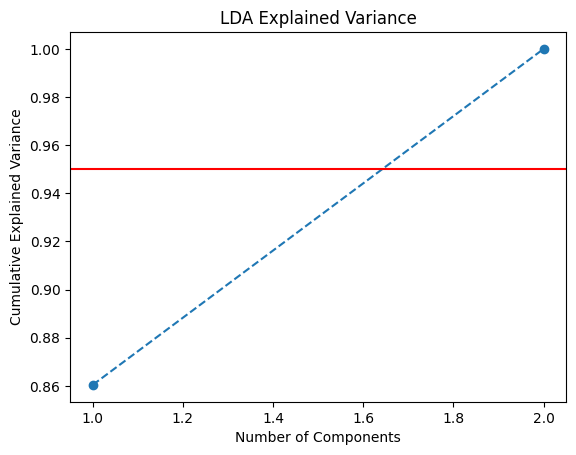

In [30]:
lda = LinearDiscriminantAnalysis()
lda.fit(X3_over_num_scaled, y1_over)

explained_variance_ratio_lda = np.cumsum(lda.explained_variance_ratio_)
n_components_optimal_lda = np.argmax(explained_variance_ratio_lda >= 0.95) + 1
print(f"Optimal number of components: {n_components_optimal_lda}")

plt.plot(range(1, len(explained_variance_ratio_lda) + 1), explained_variance_ratio_lda, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("LDA Explained Variance")
plt.show()

In [31]:
y3 = y1_over

lda = LinearDiscriminantAnalysis(n_components=n_components_optimal_lda)
X3_numeric_lda = lda.fit_transform(X3_over_num_scaled, y3)

X3_cat_df = pd.DataFrame(X3_over_cat_scaled, columns=X_categorical.columns)
X3_num_df = pd.DataFrame(X3_numeric_lda, columns=[f'LD{i+1}' for i in range(X3_numeric_lda.shape[1])])
X3 = pd.concat([X3_cat_df, X3_num_df], axis=1)

display(X3)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,International,LD1,LD2
0,-0.279215,-0.118484,2.808832,-4.192639,0.353193,-0.349564,-0.127134,-0.014144,-0.656651,-0.086213,1.048084,-0.088065,-0.304702,0.440760,1.492108,-0.463037,-0.135223,-0.452257,0.188451
1,-0.279215,-0.233708,-0.526286,0.194645,0.353193,-0.349564,-0.127134,-1.178529,-1.245805,-0.312557,1.048084,-0.088065,-0.304702,-2.268809,1.492108,-0.463037,-0.135223,1.673478,0.832053
2,-0.279215,-1.040277,2.808832,0.105769,0.353193,-0.349564,-0.127134,1.150241,0.979889,-0.086213,1.048084,-0.088065,-0.304702,-2.268809,1.492108,-0.463037,-0.135223,-2.223342,1.819191
3,-0.279215,-0.118484,0.307493,0.445333,0.353193,-0.349564,-0.127134,1.214929,0.979889,-0.312557,1.048084,-0.088065,-0.304702,0.440760,-0.670193,-0.463037,-0.135223,0.757652,-0.673785
4,1.533086,1.148981,-0.526286,-0.404302,-2.831312,-0.349564,-0.127134,1.150241,1.045350,-0.086213,-0.954122,-0.088065,-0.304702,0.440760,-0.670193,-0.463037,-0.135223,0.950136,1.358101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6622,-0.279215,-1.040277,-0.526286,0.483975,0.353193,-0.349564,-0.127134,-0.984465,-1.376728,-0.161661,1.048084,-0.088065,-0.304702,0.440760,-0.670193,-0.463037,-0.135223,0.277332,-0.717543
6623,-0.279215,-0.118484,1.975052,0.313468,0.353193,-0.349564,-0.127134,-1.178529,-1.376728,-0.274833,1.048084,-0.088065,-0.304702,0.440760,-0.670193,-0.463037,-0.135223,1.578437,1.028785
6624,-0.279215,-1.040277,-0.526286,0.142962,0.353193,-0.349564,-0.127134,1.150241,0.979889,-0.086213,-0.954122,-0.088065,-0.304702,0.440760,-0.670193,-0.463037,-0.135223,-0.103359,-1.339013
6625,1.533086,1.148981,-0.526286,0.550632,-2.831312,3.400351,-0.127134,1.150241,-0.198420,-0.237109,-0.954122,-0.088065,-0.304702,0.440760,-0.670193,-0.463037,-0.135223,0.853168,0.339445


In [32]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.30, random_state=42, stratify=y3)
print(f'SVC + LDA - Students Academic Success Prediction')
print(X3_train.shape)
print(X3_test.shape)

SVC + LDA - Students Academic Success Prediction
(4638, 19)
(1989, 19)


In [33]:
grid5 = GridSearchCV(svc, param_grid_3, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start5 = time() 
grid5.fit(X3_train, y3_train)
print("GridSearchCV took %.2f seconds." % (time() - start5))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
GridSearchCV took 140.09 seconds.


In [34]:
best_model_5 = grid5.best_estimator_
print("SVC + LDA")
print("Best Parameters:", grid5.best_params_)
print("Best Accuracy:", grid5.best_score_)

SVC + LDA
Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.7626192668228993


In [35]:
# SVC-LDA-GridSearch - Accuracy and Confusion Matrix
print('SVC + LDA')
print(f"Accuracy = {best_model_5.score(X3_test, y3_test)}")
print('Confusion Matrix')
y3_test_pred = best_model_5.predict(X3_test)
print(confusion_matrix(y3_test, y3_test_pred))

# SVC-LDA-GridSearch - Classification Report
print(classification_report(y3_test, y3_test_pred, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + LDA
Accuracy = 0.7692307692307693
Confusion Matrix
[[479 122  62]
 [ 59 508  96]
 [ 26  94 543]]
              precision    recall  f1-score   support

     Dropout       0.85      0.72      0.78       663
    Enrolled       0.70      0.77      0.73       663
    Graduate       0.77      0.82      0.80       663

    accuracy                           0.77      1989
   macro avg       0.78      0.77      0.77      1989
weighted avg       0.78      0.77      0.77      1989



This SVC model (76.9% accuracy and 77% F1 score) did not perform better than SVC model trained on the whole (cleaned) feature space (78.6% accuracy and 79% F1 score) and SVC + PCA model (83.2% accuracy and 83% F1 score). This could possibly be attributed to the total number of features used in this model (19 features only).

### Logistic Regression Model with LDA

In [36]:
grid6 = GridSearchCV(base_logreg, param_grid_4, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start6 = time() 
grid6.fit(X3_train, y3_train)

print("GridSearchCV took %.2f seconds."
      % (time() - start6))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
GridSearchCV took 0.70 seconds.


In [37]:
best_model_6 = grid6.best_estimator_
print("LR + LDA")
print("Best Parameters:", grid6.best_params_)
print("Best Accuracy:", grid6.best_score_)

LR + LDA
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best Accuracy: 0.7473103355280288


In [38]:
# LR-LDA-GridSearch - Accuracy and Confusion Matrix
print('LR + LDA')
print(f"Accuracy = {best_model_6.score(X3_test, y3_test)}")
print('Confusion Matrix')
y3_test_pred2 = best_model_6.predict(X3_test)
print(confusion_matrix(y3_test, y3_test_pred2))

# LR-LDA-GridSearch - Classification Report
print(classification_report(y3_test, y3_test_pred2, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + LDA
Accuracy = 0.7295123177476118
Confusion Matrix
[[466 145  52]
 [ 95 441 127]
 [ 16 103 544]]
              precision    recall  f1-score   support

     Dropout       0.81      0.70      0.75       663
    Enrolled       0.64      0.67      0.65       663
    Graduate       0.75      0.82      0.78       663

    accuracy                           0.73      1989
   macro avg       0.73      0.73      0.73      1989
weighted avg       0.73      0.73      0.73      1989



This logistic regression + LDA model still did not exceed the performance of the SVC + LDA model. In all 3 dimensionality reduction methods conducted in this notebook (i.e. None, PCA, and LDA), SVC outperformed logistic regression model.

## Summary of Model Evaluation Results

### No Dimensionality Reduction (OvO vs. OvR, SVC vs. LogReg)

In [39]:
# SVC-OvO-GridSearch
print('SVC-OvO')
print(f"Accuracy = {best_model_1_ovo.score(X1_test, y1_test)}")
print('Confusion Matrix')
print(confusion_matrix(y1_test, y1_test_pred_ovo))
print(classification_report(y1_test, y1_test_pred_ovo, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC-OvO
Accuracy = 0.7863247863247863
Confusion Matrix
[[487 114  62]
 [ 55 519  89]
 [ 29  76 558]]
              precision    recall  f1-score   support

     Dropout       0.85      0.73      0.79       663
    Enrolled       0.73      0.78      0.76       663
    Graduate       0.79      0.84      0.81       663

    accuracy                           0.79      1989
   macro avg       0.79      0.79      0.79      1989
weighted avg       0.79      0.79      0.79      1989



In [40]:
# SVC-OvR-GridSearch
print('SVC-OvR')
print(f"Accuracy = {best_model_1_ovr.score(X1_test, y1_test)}")
print('Confusion Matrix')
print(confusion_matrix(y1_test, y1_test_pred_ovr))
print(classification_report(y1_test, y1_test_pred_ovr, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC-OvR
Accuracy = 0.7853192559074912
Confusion Matrix
[[477 113  73]
 [ 50 524  89]
 [ 31  71 561]]
              precision    recall  f1-score   support

     Dropout       0.85      0.72      0.78       663
    Enrolled       0.74      0.79      0.76       663
    Graduate       0.78      0.85      0.81       663

    accuracy                           0.79      1989
   macro avg       0.79      0.79      0.79      1989
weighted avg       0.79      0.79      0.79      1989



In [41]:
# LR-OvO-GridSearch
print('LR-OvO')
print(f"Accuracy = {best_model_2_ovo.score(X1_test, y1_test)}")
print('Confusion Matrix')
print(confusion_matrix(y1_test, y1_test_pred_ovo2))
print(classification_report(y1_test, y1_test_pred_ovo2, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR-OvO
Accuracy = 0.7410759175465058
Confusion Matrix
[[476 126  61]
 [ 98 446 119]
 [ 23  88 552]]
              precision    recall  f1-score   support

     Dropout       0.80      0.72      0.76       663
    Enrolled       0.68      0.67      0.67       663
    Graduate       0.75      0.83      0.79       663

    accuracy                           0.74      1989
   macro avg       0.74      0.74      0.74      1989
weighted avg       0.74      0.74      0.74      1989



In [42]:
# LR-OvR-GridSearch
print('LR-OvR')
print(f"Accuracy = {best_model_2_ovr.score(X1_test, y1_test)}")
print('Confusion Matrix')
print(confusion_matrix(y1_test, y1_test_pred_ovr2))
print(classification_report(y1_test, y1_test_pred_ovr2, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR-OvR
Accuracy = 0.730517848164907
Confusion Matrix
[[480 121  62]
 [110 424 129]
 [ 22  92 549]]
              precision    recall  f1-score   support

     Dropout       0.78      0.72      0.75       663
    Enrolled       0.67      0.64      0.65       663
    Graduate       0.74      0.83      0.78       663

    accuracy                           0.73      1989
   macro avg       0.73      0.73      0.73      1989
weighted avg       0.73      0.73      0.73      1989



### With Principal Component Analysis (SVC vs. LogReg)

In [43]:
# SVC-PCA-GridSearch
print('SVC + PCA')
print(f"Accuracy = {best_model_3.score(X2_test, y2_test)}")
print('Confusion Matrix')
print(confusion_matrix(y2_test, y2_test_pred))
print(classification_report(y2_test, y2_test_pred, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + PCA
Accuracy = 0.8320764203117145
Confusion Matrix
[[561  54  48]
 [ 35 585  43]
 [ 69  85 509]]
              precision    recall  f1-score   support

     Dropout       0.84      0.85      0.84       663
    Enrolled       0.81      0.88      0.84       663
    Graduate       0.85      0.77      0.81       663

    accuracy                           0.83      1989
   macro avg       0.83      0.83      0.83      1989
weighted avg       0.83      0.83      0.83      1989



In [44]:
# LR-PCA-GridSearch
print('LR + PCA')
print(f"Accuracy = {best_model_4.score(X2_test, y2_test)}")
print('Confusion Matrix')
print(confusion_matrix(y2_test, y2_test_pred2))
print(classification_report(y2_test, y2_test_pred2, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + PCA
Accuracy = 0.7003519356460532
Confusion Matrix
[[467 137  59]
 [ 93 435 135]
 [ 30 142 491]]
              precision    recall  f1-score   support

     Dropout       0.79      0.70      0.75       663
    Enrolled       0.61      0.66      0.63       663
    Graduate       0.72      0.74      0.73       663

    accuracy                           0.70      1989
   macro avg       0.71      0.70      0.70      1989
weighted avg       0.71      0.70      0.70      1989



### With Linear Discriminant Analysis

In [45]:
# SVC-LDA-GridSearch
print('SVC + LDA')
print(f"Accuracy = {best_model_5.score(X3_test, y3_test)}")
print('Confusion Matrix')
print(confusion_matrix(y3_test, y3_test_pred))
print(classification_report(y3_test, y3_test_pred, target_names=['Dropout', 'Enrolled', 'Graduate']))

SVC + LDA
Accuracy = 0.7692307692307693
Confusion Matrix
[[479 122  62]
 [ 59 508  96]
 [ 26  94 543]]
              precision    recall  f1-score   support

     Dropout       0.85      0.72      0.78       663
    Enrolled       0.70      0.77      0.73       663
    Graduate       0.77      0.82      0.80       663

    accuracy                           0.77      1989
   macro avg       0.78      0.77      0.77      1989
weighted avg       0.78      0.77      0.77      1989



In [46]:
# LR-LDA-GridSearch
print('LR + LDA')
print(f"Accuracy = {best_model_6.score(X3_test, y3_test)}")
print('Confusion Matrix')
print(confusion_matrix(y3_test, y3_test_pred2))
print(classification_report(y3_test, y3_test_pred2, target_names=['Dropout', 'Enrolled', 'Graduate']))

LR + LDA
Accuracy = 0.7295123177476118
Confusion Matrix
[[466 145  52]
 [ 95 441 127]
 [ 16 103 544]]
              precision    recall  f1-score   support

     Dropout       0.81      0.70      0.75       663
    Enrolled       0.64      0.67      0.65       663
    Graduate       0.75      0.82      0.78       663

    accuracy                           0.73      1989
   macro avg       0.73      0.73      0.73      1989
weighted avg       0.73      0.73      0.73      1989



Overall best performing model: <b>SVC + PCA</b>

Overall worst performing model: <b>LogReg + PCA</b>